![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4210_Analisis_con_Deep_Learning/blob/master/lab_4/practica_10/practica_10.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>

## **Práctica 10**

## **Series de Tiempo**

## **Objetivos**

*   Analizar la construcción de una Red Neuronal Recurrente.
*   Ver la aplicación de la metodología CRISP-DM en un problema de minería de datos.
*   Realizar una comparación de diferentes algoritmos para realizar predicciones.
*   Automatizar el proceso de gestión de pedidos para una comercializadora.

## Primer Problema
- Para una empresa comercializadora de productos naturales encargada del manejo de más de 1500 productos en 170 puntos de venta, realiza el pronóstico de ventas de cada producto de manera manual por los vendedores. Esto ha generado a la empresa sobrestock en los puntos de venta generando retención de mercancía evaluada en 90 millones de pesos. Por ello, se quiere crear un sistema que permita pronosticar de manera adecuada las ventas de estos productos y así evitar retenciones en la mercancía y generando una mayor rotación de inventario.

    Por ello, se ha propuesto un desarrollo de un sistema que sea capaz de pronosticar la demanda de cada uno de los productos en los diferentes puntos de venta. Con el fin de poder realizar una planeación en el punto de venta y así establecer las ventas de ese producto. Esto con el fin de poder realizar el pedido a la bodega central de manera automática y evitando generar acumulación en los puntos de venta o el no poder realizar la venta por la falta de la mercancía.





## **Importando las librerias requeridas para el desarrollo del laboratorio**


Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
path = '/content/drive/My Drive/Tesis/'
sys.path.append(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import six
import os
import os.path as osp
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import plotly.graph_objects as go
from datetime import datetime
from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm
import pickle

from numpy.random import seed
seed(33)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## **Perfilamiento y entendimiento de los datos**

#### Diccionario de Datos

Como parte del proceso de Comprensión del Negocio y Comprensión de los Datos, se construyó con la empresa un [diccionario de datos](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%207/Diccionario%20de%20Datos.pdf). Luego, se creó un archivo ya con los datos organizados y filtrados.



#### Lectura de los datos
Con el contexto claro, se leen los datos y se visualizan que se hayan leido correctamente.

In [ ]:
transacciones = pd.read_csv(path+'PLAMOV.csv',sep=';')
transacciones = transacciones.append(pd.read_csv(path+'PLAMOV2.csv',sep=';'))
transacciones.drop(['DESCRIPCION','N-BODEGA'],axis=1)

,EQUI,REFERCIA,OPE,N-OPERACION,FECHA,BODEGA,BOD-RECIBE,DOCUMENTO,CANTIDAD
0,A500,1216000061,51,VENTAS,1/01/2020,B3,0,247650.0,1.0
1,A500,1216000061,54,SAL X AJUSTE,1/01/2020,W4,NaN,63.0,1.0
2,A501,1216000062,2,ENT X TRASLADO,1/01/2020,E1,W3,224.0,1.0
3,A501,1216000062,52,SAL X TRASLADO,1/01/2020,W3,E1,224.0,1.0
4,A502,1216000063,2,ENT X TRASLADO,1/01/2020,Z5,K2,168.0,2.0
...,...,...,...,...,...,...,...,...,...
601599,A273,VIST270036,51,VENTAS,31/12/2019,J5,0,62197.0,2.0
601600,A273,VIST270036,51,VENTAS,31/12/2019,88,0,96210.0,1.0
601601,A273,VIST270036,51,VENTAS,31/12/2019,O2,0,106668.0,1.0
601602,A273,VIST270036,51,VENTAS,31/12/2019,H4,0,245647.0,1.0


## **Preparación de datos**

Para la preparación de los datos, se necesita construir las series de tiempo a evaluar, además de los filtros para obtener los movimientos necesarios.

In [ ]:
#Obtiene solo aquellas transacciones relacionadas con ventas
transacciones = transacciones[transacciones['OPE']==51]

PDV_dia = pd.pivot_table(transacciones,aggfunc='sum',columns='FECHA',
                        index=['BODEGA','EQUI'],values='CANTIDAD',fill_value=0)



zeros = lambda x: (x == 0).sum()
my_dates = list(PDV_dia.columns)
my_dates.sort(key=lambda date: datetime.strptime(date, "%d/%m/%Y"))
PDV_dia = PDV_dia[my_dates]
PDV_dia.head()

FECHA        01/10/2019  02/10/2019  ...  29/04/2020  30/04/2020
BODEGA EQUI                          ...                        
1      100            0           0  ...           0           0
       125            0           0  ...           0           0
       162            0           0  ...           0           0
       163            0           0  ...           0           0
       167            0           0  ...           0           0

[5 rows x 213 columns]

Para realizar la selección de cada modelo. Se realizpo una clasificación ABC basado en la rotación de cada uno de los productos. Donde, basados en las entrevistas a los diferentes stakeholders del proyecto y respaldando las afirmaciones a través del [Principio de Pareto](https://es.wikipedia.org/wiki/Principio_de_Pareto). Se selecionaron aquellos productos 'Categoria A' (20%) os cuales representaban el 73.20% de las ventas anuales de la compañia

In [ ]:
orden = PDV_dia.iloc[:]
zeros = lambda x: (x == 0).sum()
orden['Total'] = orden.sum(axis=1)
orden['Zeros'] = orden.apply(zeros,axis=1)
orden['Media'] = orden.mean(axis=1)
print(orden['Zeros'].describe())
orden.head()

count    64906.000000
mean       202.366592
std         17.646369
min          5.000000
25%        202.000000
50%        208.000000
75%        211.000000
max        212.000000
Name: Zeros, dtype: float64


FECHA        01/10/2019  02/10/2019  03/10/2019  ...  Total  Zeros      Media
BODEGA EQUI                                      ...                         
1      100            0           0           0  ...    573    180   6.167442
       125            0           0          83  ...   1465    199  14.553488
       162            0           0           0  ...      2    212   1.004651
       163            0           0           0  ...     52    206   1.441860
       167            0           0           0  ...     36    211   1.316279

[5 rows x 216 columns]

In [ ]:
orden['proporcion'] = orden['Zeros'] / orden['Zeros'].sum()
orden = orden.sort_values(by=['proporcion'])
orden.loc[:,'Clasificacion'] = 'C'
orden.loc[:int(len(orden)*0.5),'Clasificacion'] = 'B'
orden.loc[:int(len(orden)*0.2),'Clasificacion'] = 'A'
orden

FECHA        01/10/2019  02/10/2019  ...    proporcion  Clasificacion
BODEGA EQUI                          ...                             
S5     40            51          46  ...  3.806680e-07              A
B3     40            48          34  ...  4.568016e-07              A
45     40            23          17  ...  6.852024e-07              A
E2     40            65          65  ...  7.613359e-07              A
K1     A428           2           5  ...  8.374695e-07              A
...                 ...         ...  ...           ...            ...
O4     527            0           0  ...  1.614032e-05              C
S5     A757           0           0  ...  1.614032e-05              C
       A780           0           0  ...  1.614032e-05              C
       A699           0           0  ...  1.614032e-05              C
84     H340           0           0  ...  1.614032e-05              C

[64906 rows x 218 columns]

#### Selección de las series candidatas.
Visualización de las series candidatas para entrenar los regresores.

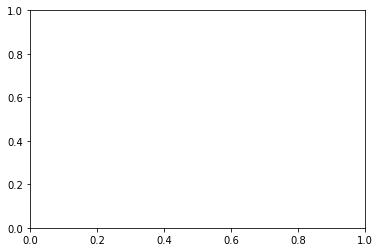

In [ ]:
nombres = [('LA 14 LIMONAR-CALI','CARAMELOS DE LECHE X 100'),('EXITO AMERICAS-BOGOTA','CARAMELOS DE LECHE X 100'),('JUMBO CALLE 80-BOGOTA','CARAMELOS DE LECHE X 100'),
          ('EXITO COLINAS-BOGOTA','CHICHARRIN GRANDE X 40 gr'),('EXITO SALITRE PLAZA-BOGOTA','CARAMELOS AJONJOLI'),('CARULLA SANTA BARBARA-BOG','CHICHARRIN GRANDE X 40 gr'),
          ('EXITO CANAVERAL','TE MEISHEN REPUESTO'),('EXITO UNICENTRO-BOGOTA','RESCATE ESENCIA'),('JUMBO CL 170-BOGOTA','GALLETA QUINUA SUGAR BOGOTA')]

fig = plt.subplots()
series = dict()
for nombre in nombres:
  d = data.iloc[data.index.get_level_values('N-BODEGA')==nombre[0]].droplevel(0)

  my_dates = list(d.columns)

  X_Real = d.loc[nombre[1],my_dates].values.astype('float32')
  series[' - '.join(nombre)] = X_Real
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=my_dates, y=X_Real,
                      mode='lines+markers',
                      name='Real'))

  fig.update_layout(
                    xaxis_title='Dia',
                    yaxis_title='Cantidad')
  fig.write_html(osp.join(path,'Predictores','Serie {0} - {1}.html'.format(nombre[0],nombre[1])))
  fig.show()

## **Modelamiento**

Para demostrar la efectividad de las Redes Convolucionales, se realizó una comparación entre Modelos Estadísticos y Algoritmos de Aprendizaje Automático.

Para este problema, se utilizaron los siguientes modelos:

| Modelos Estadisticos | Algoritmos de Aprendizaje Automatico |
|----------------------|--------------------------------------|
| Regresión Lineal     | Redes Neuronales Artificiales (MLP)  |
| Método Holt-Winters  | Redes Neuronales Recurentes (LSTM)   |
| Seasonal Arima       |                                      |

Se presentan ejemplos de los algoritmos empleados para la evaluación de las series.

### **Regresión Lineal**

In [ ]:
d = data.iloc[data.index.get_level_values('N-BODEGA')=='EXITO AMERICAS-BOGOTA'].droplevel(0)

my_dates = list(d.columns)

X_Real = d.loc['CARAMELOS DE LECHE X 100',my_dates].values.astype('float32')
pasado, futuro = 15,1
train, test = X_Real[:-31], X_Real[-30-pasado:]
train

array([ 48.,  34.,  28.,  67.,  65.,  78.,  22.,  34.,  63.,  29.,  92.,
        55.,  41.,  33.,  38., 150.,  10.,   0.,  40.,  83., 238.,  54.,
        14.,  39.,  43.,  41.,  67.,  79.,  33.,  19.,  43.,  57.,  41.,
        55.,  46.,  24.,  54., 339., 103.,  34.,  15.,  42.,  28.,  31.,
        32.,  55.,  45.,  23., 143.,  44.,  59.,  31.,   3.,   2.,  66.,
        53.,   7.,  21.,   5.,  15.,  92.,  73.,  21.,  45.,  24.,  62.,
        29.,   4.,  29.,  31.,  20.,  46.,  10.,  53.,  27.,  52.,  28.,
        39.,  23.,  17.,  65.,  34.,  53.,  32.,   9.,  16.,  16.,  30.,
        22.,  13.,  42.,   3., 112.,   8.,  20.,   9.,  57.,   9., 134.,
        59.,  10.,  23.,  72.,  31.,  41.,  57.,  34.,  23.,  30.,  18.,
        29.,  39.,  18.,  45.,  29.,  20.,  65.,   0.,  35.,  48.,  10.,
        33.,  11.,  25.,  33.,  14.,  17.,  35.,  75.,  37.,  46., 118.,
        22.,  31.,  31.,  24.,  13.,  47., 120.,  12., 102.,   7.,  21.,
        58.,  17.,  23.,  21.,  38.,  12.,   8.,   

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)


X_train, Y_train = create_dataset(train,pasado)
X_train, Y_train = pd.DataFrame(X_train, columns=['t - {0}'.format(i) for i in range(15,0,-1)]),pd.DataFrame(Y_train, columns=['t'])

X_test, Y_test = create_dataset(test,pasado)
X_test, Y_test = pd.DataFrame(X_test, columns=['t - {0}'.format(i) for i in range(15,0,-1)]),pd.DataFrame(Y_test, columns=['t'])


display(pd.DataFrame(X_train))
pd.DataFrame(Y_train)

,t - 15,t - 14,t - 13,t - 12,t - 11,t - 10,t - 9,t - 8,t - 7,t - 6,t - 5,t - 4,t - 3,t - 2,t - 1
0,48.0,34.0,28.0,67.0,65.0,78.0,22.0,34.0,63.0,29.0,92.0,55.0,41.0,33.0,38.0
1,34.0,28.0,67.0,65.0,78.0,22.0,34.0,63.0,29.0,92.0,55.0,41.0,33.0,38.0,150.0
2,28.0,67.0,65.0,78.0,22.0,34.0,63.0,29.0,92.0,55.0,41.0,33.0,38.0,150.0,10.0
3,67.0,65.0,78.0,22.0,34.0,63.0,29.0,92.0,55.0,41.0,33.0,38.0,150.0,10.0,0.0
4,65.0,78.0,22.0,34.0,63.0,29.0,92.0,55.0,41.0,33.0,38.0,150.0,10.0,0.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,27.0,31.0,2.0,50.0,30.0,28.0,29.0,54.0,72.0,37.0,14.0,29.0,8.0,49.0,11.0
163,31.0,2.0,50.0,30.0,28.0,29.0,54.0,72.0,37.0,14.0,29.0,8.0,49.0,11.0,27.0
164,2.0,50.0,30.0,28.0,29.0,54.0,72.0,37.0,14.0,29.0,8.0,49.0,11.0,27.0,38.0
165,50.0,30.0,28.0,29.0,54.0,72.0,37.0,14.0,29.0,8.0,49.0,11.0,27.0,38.0,26.0


,t
0,150.0
1,10.0
2,0.0
3,40.0
4,83.0
...,...
162,27.0
163,38.0
164,26.0
165,46.0


In [ ]:
# make predictions
trainPredict = regr.predict(X_train)
testPredict = regr.predict(X_test)
resultados = pd.DataFrame(index=['MSE','RMSE','MAE','R2'],columns=['Train','Test'])

# calculate mean squared error
trainScore = mean_squared_error(Y_train, trainPredict)
resultados.at['MSE','Train'] = '{:.2f}'.format(trainScore)
testScore = mean_squared_error(Y_test, testPredict)
resultados.at['MSE','Test'] = '{:.2f}'.format(testScore)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(Y_train, trainPredict))
resultados.at['RMSE','Train'] = '{:.2f}'.format(trainScore)
testScore = math.sqrt(mean_squared_error(Y_test, testPredict))
resultados.at['RMSE','Test'] = '{:.2f}'.format(testScore)
#calculate r2
trainScore = r2_score(Y_train, trainPredict)
resultados.at['R2','Train'] = '{:.2f}'.format(trainScore)
testScore = r2_score(Y_test, testPredict)
resultados.at['R2','Test'] = '{:.2f}'.format(testScore)
#calculate MAE
trainScore = mean_absolute_error(Y_train, trainPredict)
resultados.at['MAE','Train'] = '{:.2f}'.format(trainScore)
testScore = mean_absolute_error(Y_test, testPredict)
resultados.at['MAE','Test'] = '{:.2f}'.format(testScore)


# shift train predictions for plotting
trainPredictPlot = np.empty_like(X_Real)
trainPredictPlot[:] = np.nan
trainPredictPlot[:len(trainPredict)] = np.reshape(trainPredict,-1)
# shift test predictions for plotting
testPredictPlot = np.empty_like(X_Real)
testPredictPlot[:] = np.nan
testPredictPlot[-len(testPredict):] = np.reshape(testPredict,-1)

resultados

,Train,Test
MSE,1428.77,561.03
RMSE,37.80,23.69
MAE,22.92,20.48
R2,0.04,-2.41


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=my_dates, y=X_Real,
                    mode='lines+markers',
                    name='Real'))
fig.add_trace(go.Scatter(x=my_dates, y=trainPredictPlot,
                    mode='lines+markers',
                    name='Estimado'))
fig.add_trace(go.Scatter(x=my_dates, y=testPredictPlot,
                    mode='lines+markers',
                    name='Predecido'))

fig.update_layout(title='Prediccción con Regresion Lineal',
                   xaxis_title='Dia',
                   yaxis_title='Cantidad')
fig.show()

### **Holt-Winters**

Como se define en la literatura, el alpha se define como $2/(N+1)$ <br>
Primero, se entrena una suavización exponencial simple

In [ ]:
alpha = 2/(len(X_Real)+1)

simple = SimpleExpSmoothing(train).fit(smoothing_level=alpha,optimized=False)
print(simple.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  endog   No. Observations:                  182
Model:             SimpleExpSmoothing   SSE                         260036.049
Optimized:                      False   AIC                           1326.152
Trend:                           None   BIC                           1332.560
Seasonal:                        None   AICC                          1326.378
Seasonal Periods:                None   Date:                 Fri, 12 Jun 2020
Box-Cox:                        False   Time:                         01:25:00
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.0093458                alpha                False
initial_level              48.000000                

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
# make predictions
trainPredict = simple.fittedvalues
testPredict = simple.forecast(len(test))
resultados = pd.DataFrame(index=['MSE','RMSE','MAE','R2'],columns=['Train','Test'])

# calculate mean squared error
trainScore = mean_squared_error(train, trainPredict)
resultados.at['MSE','Train'] = '{:.2f}'.format(trainScore)
testScore = mean_squared_error(test, testPredict)
resultados.at['MSE','Test'] = '{:.2f}'.format(testScore)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train, trainPredict))
resultados.at['RMSE','Train'] = '{:.2f}'.format(trainScore)
testScore = math.sqrt(mean_squared_error(test, testPredict))
resultados.at['RMSE','Test'] = '{:.2f}'.format(testScore)
#calculate r2
trainScore = r2_score(train, trainPredict)
resultados.at['R2','Train'] = '{:.2f}'.format(trainScore)
testScore = r2_score(test, testPredict)
resultados.at['R2','Test'] = '{:.2f}'.format(testScore)
#calculate MAE
trainScore = mean_absolute_error(train, trainPredict)
resultados.at['MAE','Train'] = '{:.2f}'.format(trainScore)
testScore = mean_absolute_error(test, testPredict)
resultados.at['MAE','Test'] = '{:.2f}'.format(testScore)


# shift train predictions for plotting
trainPredictPlot = np.empty_like(X_Real)
trainPredictPlot[:] = np.nan
trainPredictPlot[:len(trainPredict)] = np.reshape(trainPredict,-1)
# shift test predictions for plotting
testPredictPlot = np.empty_like(X_Real)
testPredictPlot[:] = np.nan
testPredictPlot[-len(testPredict):] = np.reshape(testPredict,-1)

resultados

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



,Train,Test
MSE,1428.77,486.75
RMSE,37.80,22.06
MAE,24.52,18.42
R2,-0.00,-1.06


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=my_dates, y=X_Real,
                    mode='lines+markers',
                    name='Real'))
fig.add_trace(go.Scatter(x=my_dates, y=trainPredictPlot,
                    mode='lines+markers',
                    name='Estimado'))
fig.add_trace(go.Scatter(x=my_dates, y=testPredictPlot,
                    mode='lines+markers',
                    name='Predecido'))

fig.update_layout(title='Prediccción con Suavización Exponencial',
                   xaxis_title='Dia',
                   yaxis_title='Cantidad')
fig.show()

Segundo, se entrena el Modelo Holt de tendencia

In [ ]:
holt = Holt(train).fit(smoothing_level = alpha,smoothing_slope = 0.1)
print(holt.summary())

                              Holt Model Results                              
Dep. Variable:                  endog   No. Observations:                  182
Model:                           Holt   SSE                         269033.979
Optimized:                       True   AIC                           1336.343
Trend:                       Additive   BIC                           1349.159
Seasonal:                        None   AICC                          1336.823
Seasonal Periods:                None   Date:                 Fri, 12 Jun 2020
Box-Cox:                        False   Time:                         01:25:01
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.0093458                alpha                False
smoothing_slope            0.1000000                

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
# make predictions
trainPredict = holt.fittedvalues
testPredict = holt.forecast(len(test))
resultados = pd.DataFrame(index=['MSE','RMSE','MAE','R2'],columns=['Train','Test'])

# calculate mean squared error
trainScore = mean_squared_error(train, trainPredict)
resultados.at['MSE','Train'] = '{:.2f}'.format(trainScore)
testScore = mean_squared_error(test, testPredict)
resultados.at['MSE','Test'] = '{:.2f}'.format(trainScore)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train, trainPredict))
resultados.at['RMSE','Train'] = '{:.2f}'.format(trainScore)
testScore = math.sqrt(mean_squared_error(test, testPredict))
resultados.at['RMSE','Test'] = '{:.2f}'.format(trainScore)
#calculate r2
trainScore = r2_score(train, trainPredict)
resultados.at['R2','Train'] = '{:.2f}'.format(trainScore)
testScore = r2_score(test, testPredict)
resultados.at['R2','Test'] = '{:.2f}'.format(trainScore)
#calculate MAE
trainScore = mean_absolute_error(train, trainPredict)
resultados.at['MAE','Train'] = '{:.2f}'.format(trainScore)
testScore = mean_absolute_error(test, testPredict)
resultados.at['MAE','Test'] = '{:.2f}'.format(trainScore)


# shift train predictions for plotting
trainPredictPlot = np.empty_like(X_Real)
trainPredictPlot[:] = np.nan
trainPredictPlot[:len(trainPredict)] = np.reshape(trainPredict,-1)
# shift test predictions for plotting
testPredictPlot = np.empty_like(X_Real)
testPredictPlot[:] = np.nan
testPredictPlot[-len(testPredict):] = np.reshape(testPredict,-1)

resultados

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



,Train,Test
MSE,1478.21,1478.21
RMSE,38.45,38.45
MAE,23.83,23.83
R2,-0.04,-0.04


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=my_dates, y=X_Real,
                    mode='lines+markers',
                    name='Real'))
fig.add_trace(go.Scatter(x=my_dates, y=trainPredictPlot,
                    mode='lines+markers',
                    name='Estimado'))
fig.add_trace(go.Scatter(x=my_dates, y=testPredictPlot,
                    mode='lines+markers',
                    name='Predecido'))

fig.update_layout(title='Prediccción con Holt',
                   xaxis_title='Dia',
                   yaxis_title='Cantidad')
fig.show()

Y por último, se entrena el Modelo Holt-Winters.

In [ ]:
resp = []
for i in range(2,21):
    hw = ExponentialSmoothing(train ,seasonal_periods=i ,trend='add', seasonal='add',).fit()
    trainPredict = hw.fittedvalues
    resp.append( r2_score(train, trainPredict))

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(2,21)), y=resp,
                    mode='lines+markers', name = 'R^2'))


fig.update_layout(title='Estimacion estacionalidad')
fig.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/statsm

In [ ]:
hw = ExponentialSmoothing(train ,seasonal_periods=15 ,trend='add', seasonal='add',).fit()

# make predictions
trainPredict = hw.fittedvalues
testPredict = hw.forecast(len(test))
resultados = pd.DataFrame(index=['MSE','RMSE','MAE','R2'],columns=['Train','Test'])

# calculate mean squared error
trainScore = mean_squared_error(train, trainPredict)
resultados.at['MSE','Train'] = '{:.2f}'.format(trainScore)
testScore = mean_squared_error(test, testPredict)
resultados.at['MSE','Test'] = '{:.2f}'.format(testScore)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train, trainPredict))
resultados.at['RMSE','Train'] = '{:.2f}'.format(trainScore)
testScore = math.sqrt(mean_squared_error(test, testPredict))
resultados.at['RMSE','Test'] = '{:.2f}'.format(testScore)
#calculate r2
trainScore = r2_score(train, trainPredict)
resultados.at['R2','Train'] = '{:.2f}'.format(trainScore)
testScore = r2_score(test, testPredict)
resultados.at['R2','Test'] = '{:.2f}'.format(testScore)
#calculate MAE
trainScore = mean_absolute_error(train, trainPredict)
resultados.at['MAE','Train'] = '{:.2f}'.format(trainScore)
testScore = mean_absolute_error(test, testPredict)
resultados.at['MAE','Test'] = '{:.2f}'.format(testScore)


# shift train predictions for plotting
trainPredictPlot = np.empty_like(X_Real)
trainPredictPlot[:] = np.nan
trainPredictPlot[:len(trainPredict)] = np.reshape(trainPredict,-1)
# shift test predictions for plotting
testPredictPlot = np.empty_like(X_Real)
testPredictPlot[:] = np.nan
testPredictPlot[-len(testPredict):] = np.reshape(testPredict,-1)

resultados

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



,Train,Test
MSE,1293.41,386.52
RMSE,35.96,19.66
MAE,22.86,16.38
R2,0.09,-0.64


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=my_dates, y=X_Real,
                    mode='lines+markers',
                    name='Real'))
fig.add_trace(go.Scatter(x=my_dates, y=trainPredictPlot,
                    mode='lines+markers',
                    name='Estimado'))
fig.add_trace(go.Scatter(x=my_dates, y=testPredictPlot,
                    mode='lines+markers',
                    name='Predecido'))

fig.update_layout(title='Prediccción con Holt-Winters',
                   xaxis_title='Dia',
                   yaxis_title='Cantidad')
fig.show()

### **SARIMA**

In [ ]:
p,q,d = 1,1,0
model = ARIMA(train, order=(p,q,d))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  181
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -950.106
Method:                       css-mle   S.D. of innovations             46.051
Date:                Fri, 12 Jun 2020   AIC                           1906.213
Time:                        02:02:49   BIC                           1915.808
Sample:                             1   HQIC                          1910.103
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0315      2.426     -0.013      0.990      -4.787       4.724
ar.L1.D.y     -0.4131      0.067     -6.131      0.000      -0.545      -0.281
                                    Roots           

In [ ]:
# make predictions
trainPredict = model_fit.fittedvalues
testPredict = model_fit.forecast(len(test))[0]
print(len(model_fit.fittedvalues))
resultados = pd.DataFrame(index=['MSE','RMSE','MAE','R2'],columns=['Train','Test'])
t = train[q:]
# calculate mean squared error
trainScore = mean_squared_error(t, trainPredict)
resultados.at['MSE','Train'] = '{:.2f}'.format(trainScore)
testScore = mean_squared_error(test, testPredict)
resultados.at['MSE','Test'] = '{:.2f}'.format(testScore)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(t, trainPredict))
resultados.at['RMSE','Train'] = '{:.2f}'.format(trainScore)
testScore = math.sqrt(mean_squared_error(test, testPredict))
resultados.at['RMSE','Test'] = '{:.2f}'.format(testScore)
#calculate r2
trainScore = r2_score(t, trainPredict)
resultados.at['R2','Train'] = '{:.2f}'.format(trainScore)
testScore = r2_score(test, testPredict)
resultados.at['R2','Test'] = '{:.2f}'.format(testScore)
#calculate MAE
trainScore = mean_absolute_error(t, trainPredict)
resultados.at['MAE','Train'] = '{:.2f}'.format(trainScore)
testScore = mean_absolute_error(test, testPredict)
resultados.at['MAE','Test'] = '{:.2f}'.format(testScore)

resultados

181


,Train,Test
MSE,3678.86,446.59
RMSE,60.65,21.13
MAE,43.64,17.60
R2,-1.56,-0.89


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=my_dates, y=X_Real,
                    mode='lines+markers',
                    name='Real'))
fig.add_trace(go.Scatter(x=my_dates[q:], y=trainPredict,
                    mode='lines+markers',
                    name='Estimado'))
fig.add_trace(go.Scatter(x=my_dates[-len(testPredict):], y=testPredict,
                    mode='lines+markers',
                    name='Predecido'))

fig.update_layout(title='Prediccción con ARIMA.',
                   xaxis_title='Dia',
                   yaxis_title='Cantidad')
fig.show()

### **MLP**

In [ ]:
d = data.iloc[data.index.get_level_values('N-BODEGA')=='EXITO AMERICAS-BOGOTA'].droplevel(0)

my_dates = list(d.columns)

X_Real = d.loc['CARAMELOS DE LECHE X 100',my_dates].values.astype('float32')
pasado, futuro = 15,1
train, test = X_Real[:-31], X_Real[-30-pasado:]
train

array([ 48.,  34.,  28.,  67.,  65.,  78.,  22.,  34.,  63.,  29.,  92.,
        55.,  41.,  33.,  38., 150.,  10.,   0.,  40.,  83., 238.,  54.,
        14.,  39.,  43.,  41.,  67.,  79.,  33.,  19.,  43.,  57.,  41.,
        55.,  46.,  24.,  54., 339., 103.,  34.,  15.,  42.,  28.,  31.,
        32.,  55.,  45.,  23., 143.,  44.,  59.,  31.,   3.,   2.,  66.,
        53.,   7.,  21.,   5.,  15.,  92.,  73.,  21.,  45.,  24.,  62.,
        29.,   4.,  29.,  31.,  20.,  46.,  10.,  53.,  27.,  52.,  28.,
        39.,  23.,  17.,  65.,  34.,  53.,  32.,   9.,  16.,  16.,  30.,
        22.,  13.,  42.,   3., 112.,   8.,  20.,   9.,  57.,   9., 134.,
        59.,  10.,  23.,  72.,  31.,  41.,  57.,  34.,  23.,  30.,  18.,
        29.,  39.,  18.,  45.,  29.,  20.,  65.,   0.,  35.,  48.,  10.,
        33.,  11.,  25.,  33.,  14.,  17.,  35.,  75.,  37.,  46., 118.,
        22.,  31.,  31.,  24.,  13.,  47., 120.,  12., 102.,   7.,  21.,
        58.,  17.,  23.,  21.,  38.,  12.,   8.,   

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)


X_train, Y_train = create_dataset(train,pasado)
X_train, Y_train = pd.DataFrame(X_train, columns=['t - {0}'.format(i) for i in range(15,0,-1)]),pd.DataFrame(Y_train, columns=['t'])

X_test, Y_test = create_dataset(test,pasado)
X_test, Y_test = pd.DataFrame(X_test, columns=['t - {0}'.format(i) for i in range(15,0,-1)]),pd.DataFrame(Y_test, columns=['t'])


display(pd.DataFrame(X_train))
pd.DataFrame(Y_train)

,t - 15,t - 14,t - 13,t - 12,t - 11,t - 10,t - 9,t - 8,t - 7,t - 6,t - 5,t - 4,t - 3,t - 2,t - 1
0,48.0,34.0,28.0,67.0,65.0,78.0,22.0,34.0,63.0,29.0,92.0,55.0,41.0,33.0,38.0
1,34.0,28.0,67.0,65.0,78.0,22.0,34.0,63.0,29.0,92.0,55.0,41.0,33.0,38.0,150.0
2,28.0,67.0,65.0,78.0,22.0,34.0,63.0,29.0,92.0,55.0,41.0,33.0,38.0,150.0,10.0
3,67.0,65.0,78.0,22.0,34.0,63.0,29.0,92.0,55.0,41.0,33.0,38.0,150.0,10.0,0.0
4,65.0,78.0,22.0,34.0,63.0,29.0,92.0,55.0,41.0,33.0,38.0,150.0,10.0,0.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,27.0,31.0,2.0,50.0,30.0,28.0,29.0,54.0,72.0,37.0,14.0,29.0,8.0,49.0,11.0
163,31.0,2.0,50.0,30.0,28.0,29.0,54.0,72.0,37.0,14.0,29.0,8.0,49.0,11.0,27.0
164,2.0,50.0,30.0,28.0,29.0,54.0,72.0,37.0,14.0,29.0,8.0,49.0,11.0,27.0,38.0
165,50.0,30.0,28.0,29.0,54.0,72.0,37.0,14.0,29.0,8.0,49.0,11.0,27.0,38.0,26.0


,t
0,150.0
1,10.0
2,0.0
3,40.0
4,83.0
...,...
162,27.0
163,38.0
164,26.0
165,46.0


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

pasado, futuro = 8,1
X_train, Y_train = create_dataset(train,pasado)

X_test, Y_test = create_dataset(test,pasado)

# create and fit the MLP network
model = Sequential(name="MLP")
model.add(Dense(20 ,input_dim=8, activation='relu'))
model.add(Dense(futuro,name='Respuesta'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=1000, verbose=2)
print(model.summary())


Epoch 1/1000
 - 0s - loss: 4370.2317
Epoch 2/1000
 - 0s - loss: 3727.4918
Epoch 3/1000
 - 0s - loss: 3187.2679
Epoch 4/1000
 - 0s - loss: 2753.3298
Epoch 5/1000
 - 0s - loss: 2435.8071
Epoch 6/1000
 - 0s - loss: 2224.3415
Epoch 7/1000
 - 0s - loss: 2070.7474
Epoch 8/1000
 - 0s - loss: 1969.1844
Epoch 9/1000
 - 0s - loss: 1900.0821
Epoch 10/1000
 - 0s - loss: 1858.1617
Epoch 11/1000
 - 0s - loss: 1824.4620
Epoch 12/1000
 - 0s - loss: 1789.9066
Epoch 13/1000
 - 0s - loss: 1762.4104
Epoch 14/1000
 - 0s - loss: 1733.7354
Epoch 15/1000
 - 0s - loss: 1710.7621
Epoch 16/1000
 - 0s - loss: 1685.9628
Epoch 17/1000
 - 0s - loss: 1665.1390
Epoch 18/1000
 - 0s - loss: 1640.6640
Epoch 19/1000
 - 0s - loss: 1620.3032
Epoch 20/1000
 - 0s - loss: 1604.1224
Epoch 21/1000
 - 0s - loss: 1587.5985
Epoch 22/1000
 - 0s - loss: 1574.0219
Epoch 23/1000
 - 0s - loss: 1559.8093
Epoch 24/1000
 - 0s - loss: 1547.3905
Epoch 25/1000
 - 0s - loss: 1533.7002
Epoch 26/1000
 - 0s - loss: 1524.4201
Epoch 27/1000
 - 0s -

In [ ]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
resultados = pd.DataFrame(index=['MSE','RMSE','MAE','R2'],columns=['Train','Test'])

# calculate mean squared error
trainScore = mean_squared_error(Y_train, trainPredict)
resultados.at['MSE','Train'] = '{:.2f}'.format(trainScore)
testScore = mean_squared_error(Y_test, testPredict)
resultados.at['MSE','Test'] = '{:.2f}'.format(testScore)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(Y_train, trainPredict))
resultados.at['RMSE','Train'] = '{:.2f}'.format(trainScore)
testScore = math.sqrt(mean_squared_error(Y_test, testPredict))
resultados.at['RMSE','Test'] = '{:.2f}'.format(testScore)
#calculate r2
trainScore = r2_score(Y_train, trainPredict)
resultados.at['R2','Train'] = '{:.2f}'.format(trainScore)
testScore = r2_score(Y_test, testPredict)
resultados.at['R2','Test'] = '{:.2f}'.format(testScore)
#calculate MAE
trainScore = mean_absolute_error(Y_train, trainPredict)
resultados.at['MAE','Train'] = '{:.2f}'.format(trainScore)
testScore = mean_absolute_error(Y_test, testPredict)
resultados.at['MAE','Test'] = '{:.2f}'.format(testScore)


# shift train predictions for plotting
trainPredictPlot = np.empty_like(X_Real)
trainPredictPlot[:] = np.nan
trainPredictPlot[:len(trainPredict)] = np.reshape(trainPredict,-1)
# shift test predictions for plotting
testPredictPlot = np.empty_like(X_Real)
testPredictPlot[:] = np.nan
testPredictPlot[-len(testPredict):] = np.reshape(testPredict,-1)

display(resultados)

fig = go.Figure()
fig.add_trace(go.Scatter(x=my_dates, y=X_Real,
                        mode='lines+markers',
                        name='Real'))   

fig.add_trace(go.Scatter(x=my_dates[pasado+1:], y=trainPredictPlot,
                        mode='lines+markers',
                        name='Estimado [{0}]'.format(pasado)))
fig.add_trace(go.Scatter(x=my_dates, y=testPredictPlot,
                        mode='lines+markers',
                        name='Predecido [{0}]'.format(pasado)))
        

fig.update_layout(title='Prediccción con Ventana [{0}]'.format(pasado),
                          xaxis_title='Dia',
                          yaxis_title='Cantidad')
fig.show()  

,Train,Test
MSE,828.27,412.15
RMSE,28.78,20.30
MAE,16.38,16.03
R2,0.44,-0.75


### **LSTM**

In [ ]:
d = data.iloc[data.index.get_level_values('N-BODEGA')=='EXITO AMERICAS-BOGOTA'].droplevel(0)
my_dates = list(d.columns)


X_Real = d.loc['CARAMELOS DE LECHE X 100'].values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(np.reshape(X_Real,(-1, 1)))
dataset = np.reshape(dataset,(-1))
train, test = dataset[:-31], dataset[-46:]
train

array([0.14159292, 0.10029498, 0.08259587, 0.19764012, 0.19174041,
       0.2300885 , 0.06489675, 0.10029498, 0.18584071, 0.08554572,
       0.27138644, 0.16224189, 0.12094395, 0.09734513, 0.11209439,
       0.44247788, 0.02949852, 0.        , 0.1179941 , 0.24483776,
       0.7020649 , 0.15929204, 0.04129793, 0.11504425, 0.12684366,
       0.12094395, 0.19764012, 0.23303835, 0.09734513, 0.0560472 ,
       0.12684366, 0.16814159, 0.12094395, 0.16224189, 0.13569322,
       0.07079646, 0.15929204, 1.        , 0.3038348 , 0.10029498,
       0.04424779, 0.1238938 , 0.08259587, 0.09144543, 0.09439528,
       0.16224189, 0.13274336, 0.06784661, 0.4218289 , 0.12979351,
       0.1740413 , 0.09144543, 0.00884956, 0.0058997 , 0.19469026,
       0.15634218, 0.02064897, 0.0619469 , 0.01474926, 0.04424779,
       0.27138644, 0.21533923, 0.0619469 , 0.13274336, 0.07079646,
       0.18289086, 0.08554572, 0.01179941, 0.08554572, 0.09144543,
       0.05899705, 0.13569322, 0.02949852, 0.15634218, 0.07964

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

pasado, futuro = 8,1
X_train, Y_train = create_dataset(train,pasado)
X_test, Y_test = create_dataset(test,pasado)
display(pd.DataFrame(X_train))
pd.DataFrame(Y_train)

,0,1,2,3,4,5,6,7
0,0.141593,0.100295,0.082596,0.197640,0.191740,0.230089,0.064897,0.100295
1,0.100295,0.082596,0.197640,0.191740,0.230089,0.064897,0.100295,0.185841
2,0.082596,0.197640,0.191740,0.230089,0.064897,0.100295,0.185841,0.085546
3,0.197640,0.191740,0.230089,0.064897,0.100295,0.185841,0.085546,0.271386
4,0.191740,0.230089,0.064897,0.100295,0.185841,0.085546,0.271386,0.162242
...,...,...,...,...,...,...,...,...
168,0.085546,0.159292,0.212389,0.109145,0.041298,0.085546,0.023599,0.144543
169,0.159292,0.212389,0.109145,0.041298,0.085546,0.023599,0.144543,0.032448
170,0.212389,0.109145,0.041298,0.085546,0.023599,0.144543,0.032448,0.079646
171,0.109145,0.041298,0.085546,0.023599,0.144543,0.032448,0.079646,0.112094


,0
0,0.185841
1,0.085546
2,0.271386
3,0.162242
4,0.120944
...,...
168,0.032448
169,0.079646
170,0.112094
171,0.076696


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
# create and fit the LSTM network
model = Sequential(name="LSTM Normalizado")
model.add(LSTM(8, input_shape=(1,pasado),name='layer_LSMT'))
model.add(Dense(futuro,name='Respuesta'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=1000, verbose=2)
print(model.summary())


Epoch 1/1000
 - 1s - loss: 0.0308
Epoch 2/1000
 - 0s - loss: 0.0259
Epoch 3/1000
 - 0s - loss: 0.0219
Epoch 4/1000
 - 0s - loss: 0.0189
Epoch 5/1000
 - 0s - loss: 0.0166
Epoch 6/1000
 - 0s - loss: 0.0151
Epoch 7/1000
 - 0s - loss: 0.0142
Epoch 8/1000
 - 0s - loss: 0.0137
Epoch 9/1000
 - 0s - loss: 0.0136
Epoch 10/1000
 - 0s - loss: 0.0135
Epoch 11/1000
 - 0s - loss: 0.0135
Epoch 12/1000
 - 0s - loss: 0.0134
Epoch 13/1000
 - 0s - loss: 0.0134
Epoch 14/1000
 - 0s - loss: 0.0134
Epoch 15/1000
 - 0s - loss: 0.0133
Epoch 16/1000
 - 0s - loss: 0.0133
Epoch 17/1000
 - 0s - loss: 0.0133
Epoch 18/1000
 - 0s - loss: 0.0132
Epoch 19/1000
 - 0s - loss: 0.0132
Epoch 20/1000
 - 0s - loss: 0.0132
Epoch 21/1000
 - 0s - loss: 0.0132
Epoch 22/1000
 - 0s - loss: 0.0131
Epoch 23/1000
 - 0s - loss: 0.0131
Epoch 24/1000
 - 0s - loss: 0.0131
Epoch 25/1000
 - 0s - loss: 0.0131
Epoch 26/1000
 - 0s - loss: 0.0131
Epoch 27/1000
 - 0s - loss: 0.0130
Epoch 28/1000
 - 0s - loss: 0.0130
Epoch 29/1000
 - 0s - loss: 0

In [ ]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
resultados = pd.DataFrame(index=['MSE','RMSE','MAE','R2'],columns=['Train','Test'])
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([Y_test])
# calculate mean squared error
trainScore = mean_squared_error(trainY[0], trainPredict[:,0])
resultados.at['MSE','Train'] = '{:.2f}'.format(trainScore)
testScore = mean_squared_error(testY[0], testPredict[:,0])
resultados.at['MSE','Test'] = '{:.2f}'.format(testScore)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
resultados.at['RMSE','Train'] = '{:.2f}'.format(trainScore)
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
resultados.at['RMSE','Test'] = '{:.2f}'.format(testScore)
#calculate r2
trainScore = r2_score(trainY[0], trainPredict[:,0])
resultados.at['R2','Train'] = '{:.2f}'.format(trainScore)
testScore = r2_score(testY[0], testPredict[:,0])
resultados.at['R2','Test'] = '{:.2f}'.format(testScore)
#calculate MAE
trainScore = r2_score(trainY[0], trainPredict[:,0])
resultados.at['MAE','Train'] = '{:.2f}'.format(trainScore)
testScore = r2_score(testY[0], testPredict[:,0])
resultados.at['MAE','Test'] = '{:.2f}'.format(testScore)


# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[pasado:len(trainPredict)+pasado] = np.reshape(trainPredict,-1)
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(pasado)+1:len(dataset)-1] = np.reshape(testPredict,-1)

print(model.name)
resultados

LSTM Normalizado


,Train,Test
MSE,1083.34,309.87
RMSE,32.91,17.60
MAE,0.29,-0.30
R2,0.29,-0.30


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=my_dates, y=X_Real,
                    mode='lines+markers',
                    name='Real'))
fig.add_trace(go.Scatter(x=my_dates, y=trainPredictPlot,
                    mode='lines+markers',
                    name='Estimado'))
fig.add_trace(go.Scatter(x=my_dates, y=testPredictPlot,
                    mode='lines+markers',
                    name='Predecido'))

fig.update_layout(title='Prediccción con '+ model.name,
                   xaxis_title='Dia',
                   yaxis_title='Cantidad')
fig.show()

## **Predicción**

Se muestran los resultados con algunas series para los 5 algoritmos [evaulados](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%207/Imagenes.pdf).


#### Serie 1

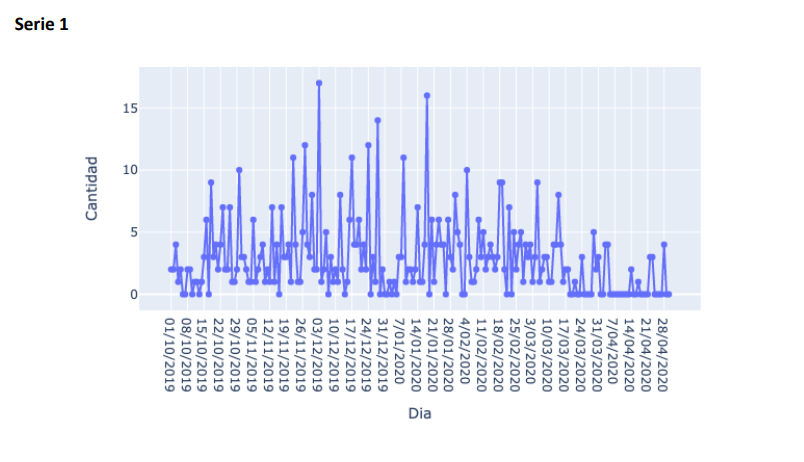

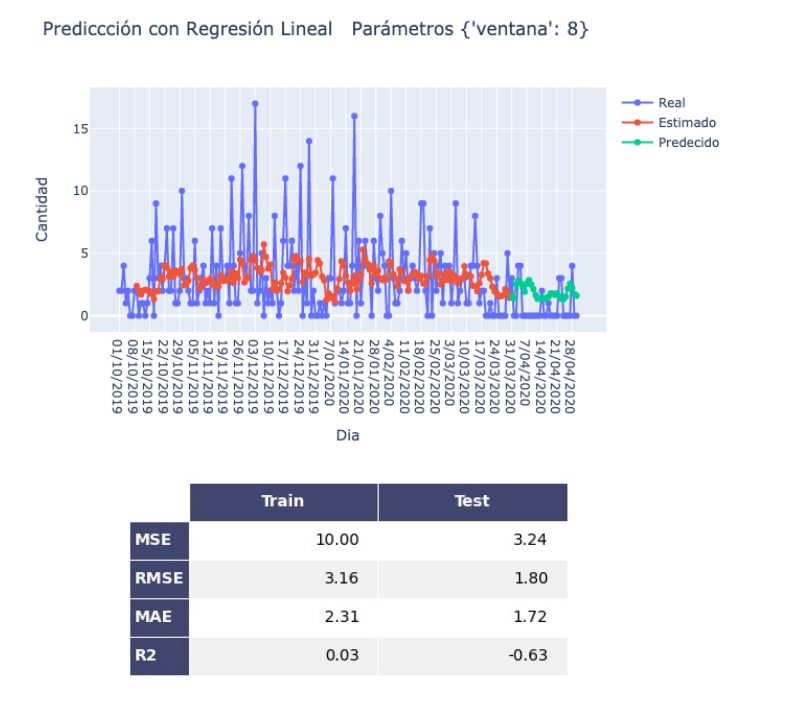

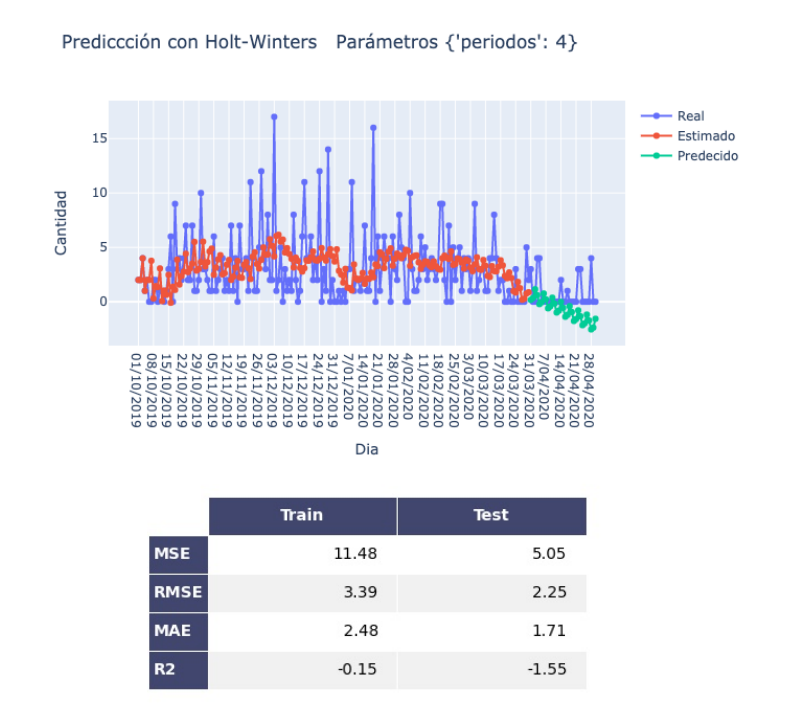

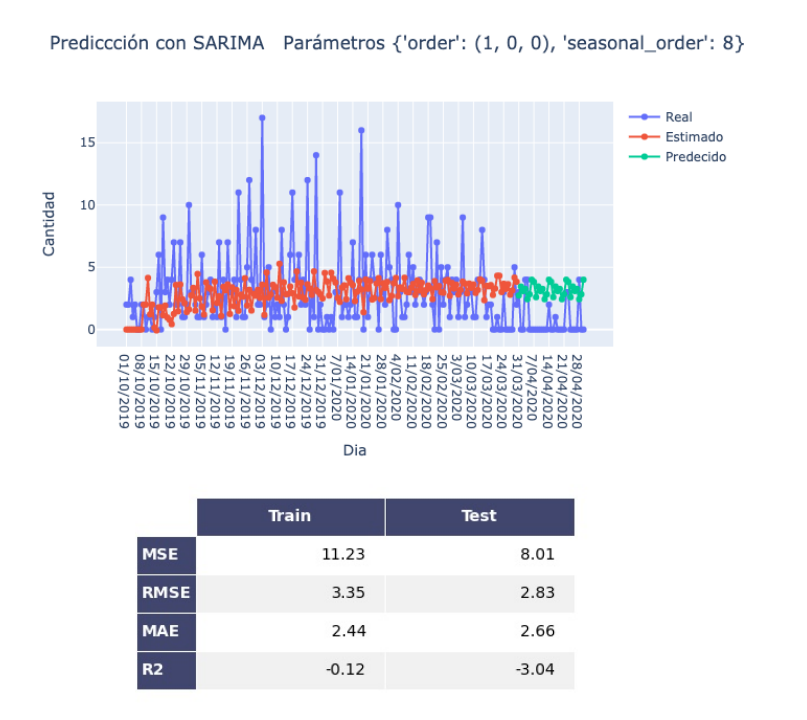

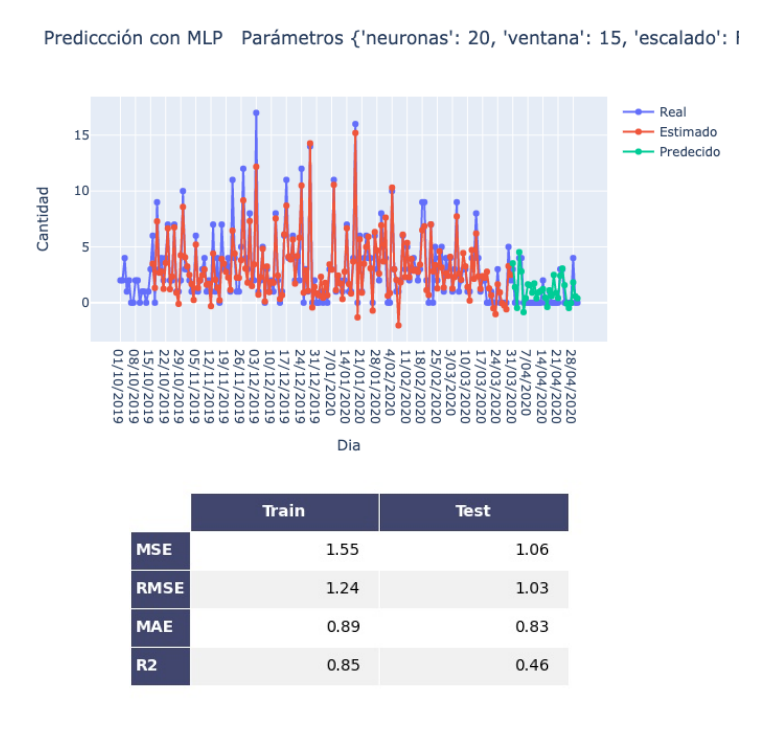

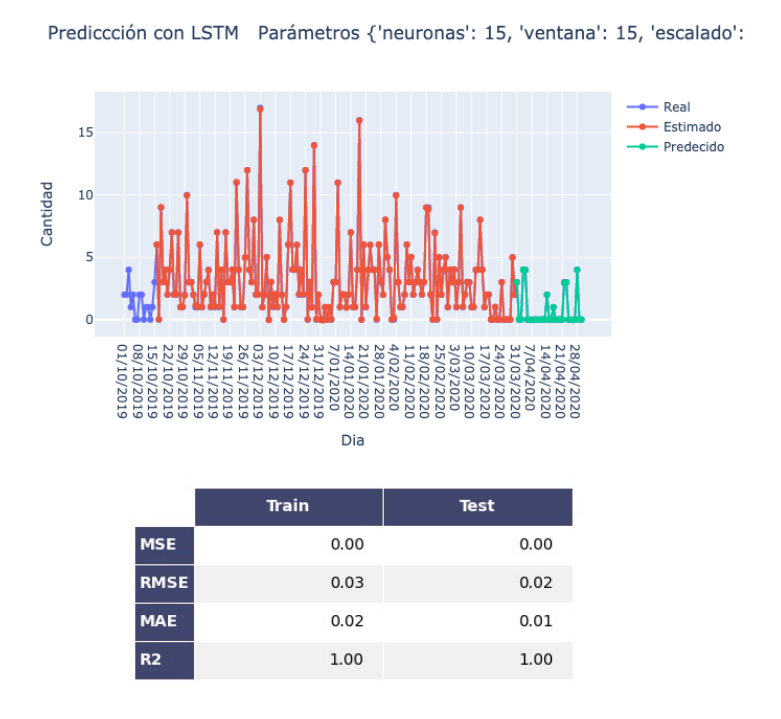

#### Serie 8

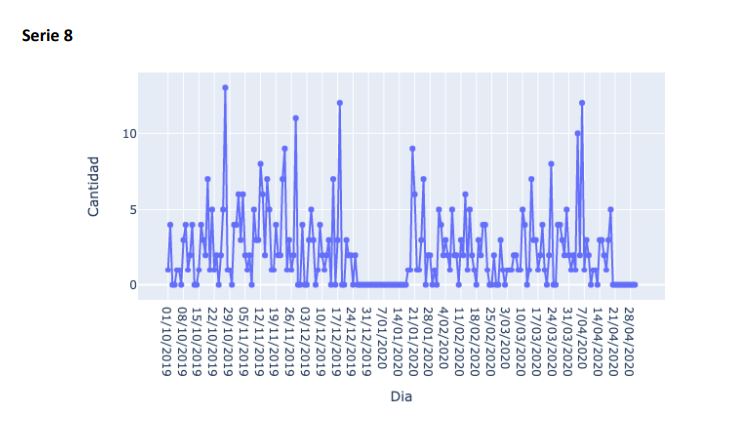

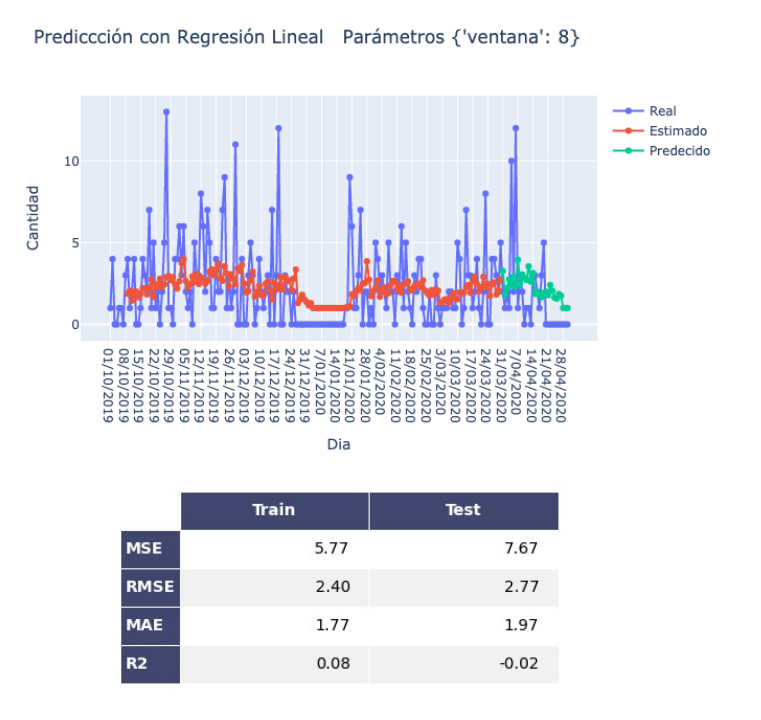

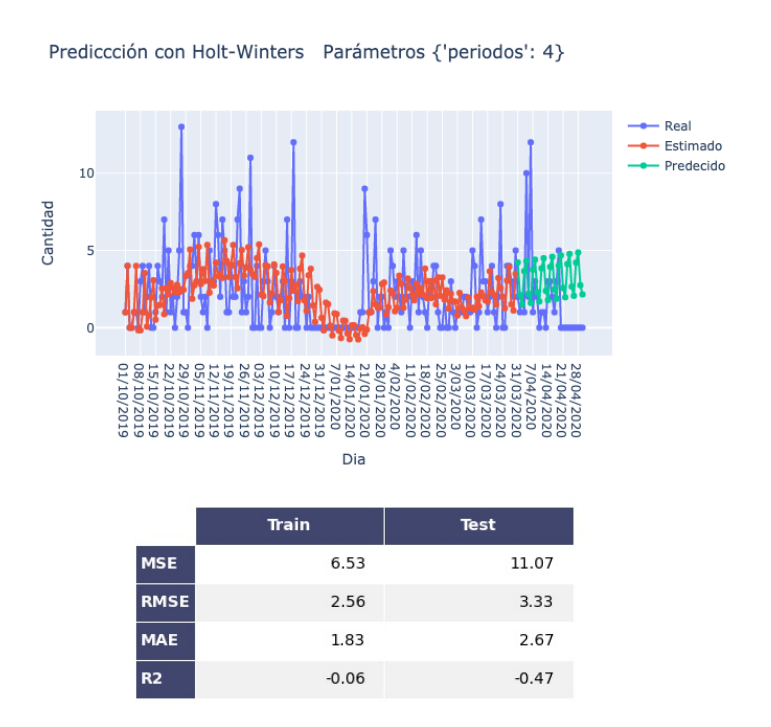

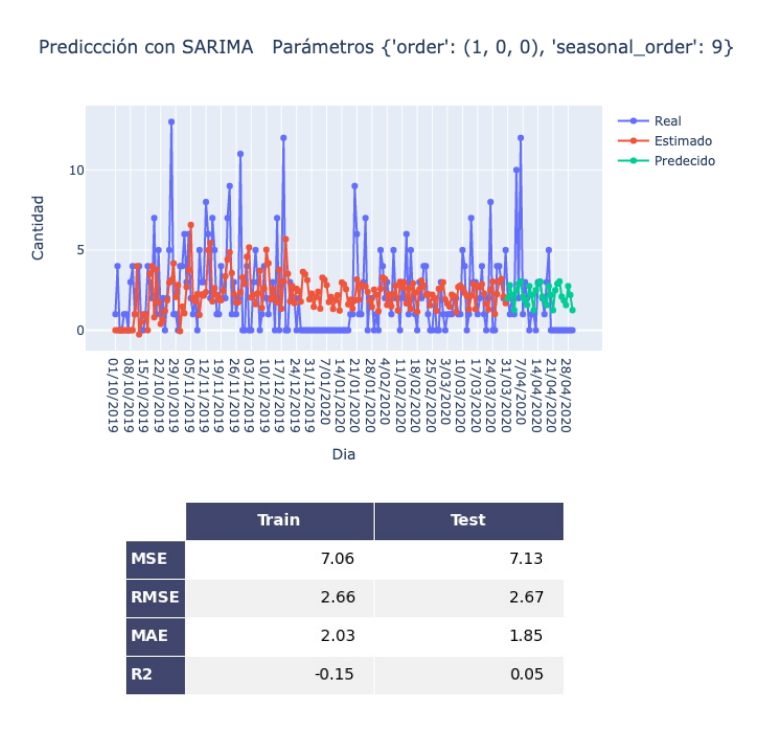

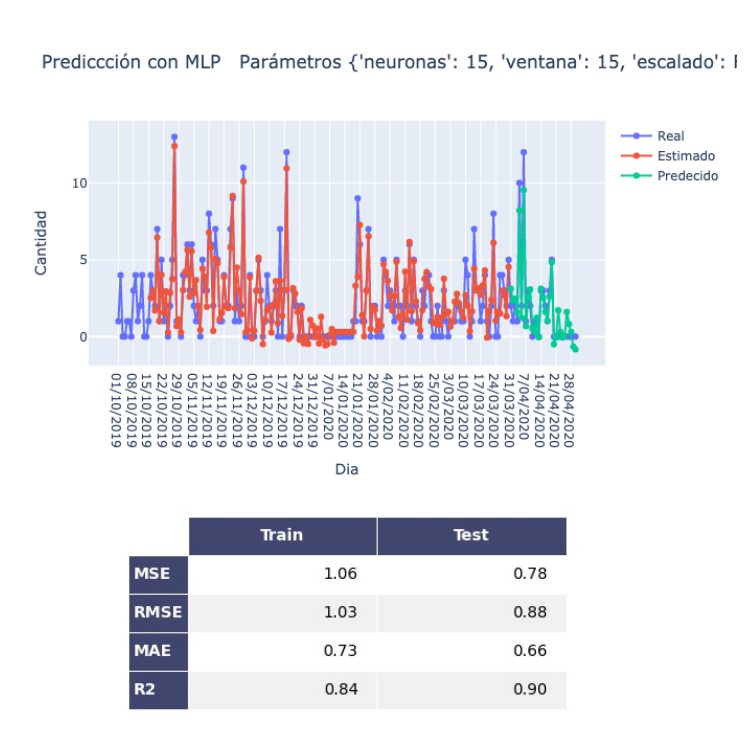

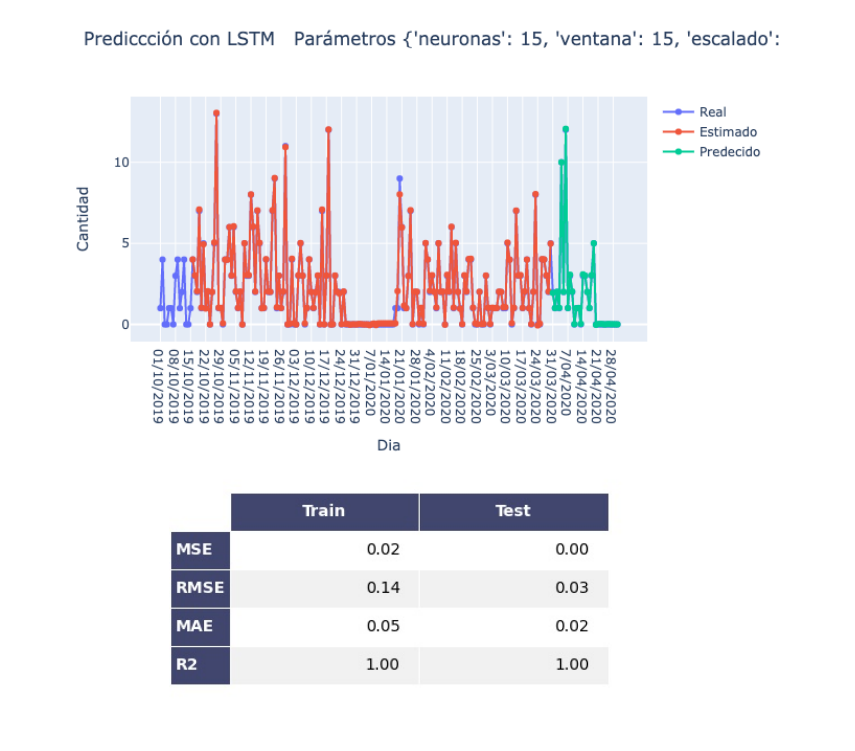

## **Validación**

Para validar los resultados, tanto como el rendimiento de los modelos como los modelos finales, se obtuvieron los siguientes resultados:


![](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%207/Pruebas.png?raw=true)

![](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%207/Resultados.png?raw=true)
